In [1]:
import mph
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import os
import math
import sys
import gpytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.quasirandom import SobolEngine
from torch.utils.data import DataLoader, TensorDataset
from copy import deepcopy
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from botorch import fit_gpytorch_model
from botorch.models import SingleTaskGP
from botorch.optim import optimize_acqf
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition import qExpectedImprovement
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.constraints.constraints import Interval
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean
from gpytorch.models import ExactGP

In [2]:
def to_unit_cube(x, lb, ub):
    """Project to [0, 1]^d from hypercube with bounds lb and ub"""
    assert np.all(lb < ub) and lb.ndim == 1 and ub.ndim == 1 and x.ndim == 2
    xx = (x - lb) / (ub - lb)
    return xx


def from_unit_cube(x, lb, ub):
    """Project from [0, 1]^d to hypercube with bounds lb and ub"""
    assert np.all(lb < ub) and lb.ndim == 1 and ub.ndim == 1 and x.ndim == 2
    xx = x * (ub - lb) + lb
    return xx


def latin_hypercube(n_pts, dim):
    """Basic Latin hypercube implementation with center perturbation."""
    X = np.zeros((n_pts, dim))
    centers = (1.0 + 2.0 * np.arange(0.0, n_pts)) / float(2 * n_pts)
    for i in range(dim):  # Shuffle the center locataions for each dimension.
        X[:, i] = centers[np.random.permutation(n_pts)]

    # Add some perturbations within each box
    pert = np.random.uniform(-1.0, 1.0, (n_pts, dim)) / float(2 * n_pts)
    X += pert
    return X

In [3]:
def save_array_numpy(array, base_filename, folder_path='.'):
    if not folder_path.endswith('/'):
        folder_path += '/'
    
    filename = base_filename + '.txt'
    unique_name = filename
    counter = 1
    while os.path.exists(folder_path + unique_name):
        unique_name = f"{base_filename}_{counter}.txt"
        counter += 1
    np.savetxt(folder_path + unique_name, array, delimiter=',')
    print(f"Array saved to {folder_path + unique_name}")

In [4]:
class GP(ExactGP):
    def __init__(self, train_x, train_y, likelihood, lengthscale_constraint, outputscale_constraint, ard_dims):
        super(GP, self).__init__(train_x, train_y, likelihood)
        self.ard_dims = ard_dims
        self.mean_module = ConstantMean()
        base_kernel = MaternKernel(lengthscale_constraint=lengthscale_constraint, ard_num_dims=ard_dims, nu=2.5)
        self.covar_module = ScaleKernel(base_kernel, outputscale_constraint=outputscale_constraint)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)


def train_gp(train_x, train_y, use_ard, num_steps, hypers={}):
    """Fit a GP model where train_x is in [0, 1]^d and train_y is standardized."""
    assert train_x.ndim == 2
    assert train_y.ndim == 1
    assert train_x.shape[0] == train_y.shape[0]

    # Create hyper parameter bounds
    noise_constraint = Interval(5e-4, 0.2)
    if use_ard:
        lengthscale_constraint = Interval(0.005, 2.0)
    else:
        lengthscale_constraint = Interval(0.005, math.sqrt(train_x.shape[1]))  # [0.005, sqrt(dim)]
    outputscale_constraint = Interval(0.05, 20.0)

    # Create models
    likelihood = GaussianLikelihood(noise_constraint=noise_constraint).to(device=train_x.device, dtype=train_y.dtype)
    ard_dims = train_x.shape[1] if use_ard else None
    model = GP(
        train_x=train_x,
        train_y=train_y,
        likelihood=likelihood,
        lengthscale_constraint=lengthscale_constraint,
        outputscale_constraint=outputscale_constraint,
        ard_dims=ard_dims,
    ).to(device=train_x.device, dtype=train_x.dtype)

    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # "Loss" for GPs - the marginal log likelihood
    mll = ExactMarginalLogLikelihood(likelihood, model)

    # Initialize model hypers
    if hypers:
        model.load_state_dict(hypers)
    else:
        hypers = {}
        hypers["covar_module.outputscale"] = 1.0
        hypers["covar_module.base_kernel.lengthscale"] = 0.5
        hypers["likelihood.noise"] = 0.005
        model.initialize(**hypers)

    # Use the adam optimizer
    optimizer = torch.optim.Adam([{"params": model.parameters()}], lr=0.1)

    for _ in range(num_steps):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

    # Switch to eval mode
    model.eval()
    likelihood.eval()

    return model

In [5]:
def average_amplitude_for_multiple_points(grid_data, Real_data, points, n):
    avg_amplitudes = []
    for point in points:
        sum_amplitudes = np.zeros((len(Real_data),))
        point_reshaped = np.reshape(point, (1, 2))
        count_within_distance = np.zeros((1), dtype=int)
        distances = np.sqrt((grid_data - point_reshaped) ** 2).sum(axis=-1)

        within_distance_indices = np.where(distances < n)[1]

        count_within_distance = len(within_distance_indices)
        if within_distance_indices.size > 0:
            sum_amplitudes[:] = Real_data[:, within_distance_indices, 2].max(axis=-1)
        
            avg_amplitude = sum_amplitudes / 1
        else:
            avg_amplitude = np.zeros((len(Real_data),))

        avg_amplitudes.append(avg_amplitude)
    
    return avg_amplitudes

def generate_coordinates(x, y, n, array=np.array([])):
    x1, y1 = x
    x2, y2 = y
    x_step = (x2 - x1) / (n + 1)
    y_step = (y2 - y1) / (n + 1)
    
    if len(array) == 0:
        array = np.array([x1, y1])

    for i in range(1, n + 1):
        x = x1 + i * x_step
        y = y1 + i * y_step
        array = np.append(array,[x, y])
    array = np.append(array,[x2, y2])
    
    return array.reshape(-1,2)

def distance(x,y):
    x1, y1 = x
    x2, y2 = y
    distance = pow(pow((x1-x2),2)+pow((y1-y2),2),0.5)
    return distance

def iteration_array_gen(array, spacing, output):
    for i in range(array.shape[0]-1):
        num = int(distance(array[i,:],array[i+1,:])/spacing)
        output = generate_coordinates(array[i,:],array[i+1,:],num, output)
    return output

In [6]:
def data_sorting(data, label, K, scaler_x = 'null', scaler_y = 'null', scaler_c = 'null', scaler_t = 'null'):
    num,row,col = data.shape
    _,col_l = label.shape
    num_set_trim = data.reshape(-1,11,row,col)
    label_trim = label.reshape(-1,11,col_l)
    num_set_trimmed = num_set_trim[:,K:11,:,:].reshape(-1,row,col)
    label_trimmed = label_trim[:,K:11,:].reshape(-1,col_l)
    if scaler_c == 'null':
        scaler_c = MinMaxScaler(feature_range=(-1,1)).fit(num_set_trimmed[:,:,2].reshape(-1,1))
    if scaler_x == 'null':
        scaler_x = MinMaxScaler(feature_range=(0,1)).fit(num_set_trimmed[:,:,0].reshape(-1,1))
    if scaler_y == 'null':
        scaler_y = MinMaxScaler(feature_range=(0,1)).fit(num_set_trimmed[:,:,1].reshape(-1,1))
    if scaler_t == 'null':
        scaler_t = MinMaxScaler(feature_range=(0,1)).fit(label_trimmed[:,2].reshape(-1,1))
        
    concent = scaler_c.transform(num_set_trimmed[:,:,2].reshape(-1,1))
    x = scaler_x.transform(num_set_trimmed[:,:,0].reshape(-1,1))
    label_x = scaler_x.transform(label_trimmed[:,0].reshape(-1,1))
    y = scaler_y.transform(num_set_trimmed[:,:,1].reshape(-1,1))
    label_y = scaler_y.transform(label_trimmed[:,1].reshape(-1,1))
    label_t = scaler_t.transform(label_trimmed[:,2].reshape(-1,1))
    Array = np.concatenate((x.reshape(-1,row,1),y.reshape(-1,row,1),concent.reshape(-1,row,1)),axis=-1)
    labels = np.concatenate((label_x.reshape(-1,1),label_y.reshape(-1,1),label_t.reshape(-1,1)),axis=-1)

    return Array, labels, scaler_x, scaler_y, scaler_c, scaler_t
    #test_predict = scaler.inverse_transform(test_predict_scaled)

In [7]:
def generate_random_points(grid_x, grid_y, num_points=5):
    return [(np.random.choice(grid_x), np.random.choice(grid_y)) for _ in range(num_points)]

def find_closest_grid_points(random_points, grid_data):
    closest_indices = []
    for x, y in random_points:
        distances = np.sqrt((grid_data[0, :, 0] - x)**2 + (grid_data[0, :, 1] - y)**2)
        closest_indices.append(np.argmin(distances, axis=0))
    return np.array(closest_indices)

def extract_sensor_data_old(grid_data, data, num_points=5, points=[]):
    num,row,col = data.shape
    grid_x = np.unique(grid_data[0, :, 0])
    grid_y = np.unique(grid_data[0, :, 1])
    random_points = np.array(points)
    if len(random_points) == 0:
        random_points = generate_random_points(grid_x, grid_y, num_points)
    closest_indices = find_closest_grid_points(random_points, grid_data)
    data_ = data.reshape(-1,9,row,col)
    sensor_data = np.zeros((int(num/9), num_points * 11))
    j= 0
    for i in range(num_points):
        sensor_data[:,i*11:i*11+2] = data_[:,0,closest_indices[i],:2].reshape(-1,2)
        sensor_data[:,i*11+2:(i+1)*11] = data_[:,:,closest_indices[i],2].reshape(-1,9)
    return sensor_data, random_points

def extract_sensor_data(grid_data, data, num_points=5, points=[],distance=4):
    num,row,col = data.shape
    grid_x = np.unique(grid_data[0, :, 0])
    grid_y = np.unique(grid_data[0, :, 1])
    random_points = np.array(points)
    if len(random_points) == 0:
        random_points = generate_random_points(grid_x, grid_y, num_points)
    closest_indices = find_closest_grid_points(random_points, grid_data)
    Average = average_amplitude_for_multiple_points(grid_data, data, points, distance)
    Average_data = np.array(Average)
    data_ = data.reshape(-1,9,row,col)
    sensor_data = np.zeros((int(num/9), num_points * 11))
    j= 0
    for i in range(num_points):
        sensor_data[:,i*11:i*11+2] = data_[:,0,closest_indices[i],:2].reshape(-1,2)
        sensor_data[:,i*11+2:(i+1)*11] = Average_data[i,:].reshape(-1,9)
    return sensor_data, random_points

In [8]:
class GasLeakDetectorNN(nn.Module):
    def __init__(self, num_sensors=5):
        super(GasLeakDetectorNN, self).__init__()
        self.num_sensors = num_sensors
        input_dim = num_sensors * 11
        
        # Define the fully connected layers
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 64)  
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.sigmoid(self.fc4(x))
        #x = F.relu(self.fc4(x))
        #x = F.relu(self.fc5(x))
        #x = self.fc4(x)
        return x

In [9]:
np_labels = np.load('./Datalabels.npy')
np_data = np.load('./Datasets.npy')
Array_X, Labels, sc_x, sc_y, sc_c, sc_t = data_sorting(np_data, np_labels, 2)
grid = np_data[0,:,:2].reshape(1,-1,2)
print(max(np_data[0,:,0]),min(np_data[0,:,0]),max(np_data[0,:,1]),min(np_data[0,:,1]))
radius = 4
Labels_trimmed = Labels.reshape(-1,9,3)[:,0,:2]

49.46751129823234 0.4675112982323418 22.44997892328108 0.44997892328107925


In [10]:
Array_X = Array_X.reshape(-1,9,4455,3)
indices = np.arange(Array_X.shape[0])
print(Array_X.shape, Labels_trimmed.shape)
np.random.shuffle(indices)
D1 = Array_X[indices]
D2 = Labels_trimmed[indices]
c11, _,_,_ = D1.shape
RoundC = round(c11*0.8)+1
RoundC2 = round(c11*1)+1
D_Train = D1[:RoundC, :]
D_Valid = D1[RoundC:RoundC2, :]
D_Train_L = D2[:RoundC, :]
D_Valid_L = D2[RoundC:RoundC2, :]
print(np_data.shape)

(1041, 9, 4455, 3) (1041, 2)
(11451, 4455, 3)


In [11]:
print(Labels[:,1].max())

0.9203555034872237


In [12]:
scalers = [sc_x, sc_y, sc_c, sc_t]

In [13]:
Sensor_coord = [25.7148,17.1982],[16.4658, 14.9485],[15,15], [20,13],[27.5,13.2] ,[20.6910,9.2276],[30.0131,14.0141],[45.2932,8.4008],[37,8],[39.5,15],[35,5],[18,10]

In [14]:
def objective_function(sensor_coordinates, grid_data, D_Train_, D_Valid_, D_Train_L, D_Valid_L, scaler, epochs=400, batch_size=64, scale = True):
    #sensor value extraction
    sensor_coordinates = np.array(sensor_coordinates)
    D_Train_E = D_Train_.reshape(-1,4455,3)
    D_Valid_E = D_Valid_.reshape(-1,4455,3)
    
    D_Train_w,_ = extract_sensor_data(grid_data, D_Train_E, len(sensor_coordinates), sensor_coordinates)
    D_Valid_w,_ = extract_sensor_data(grid_data, D_Valid_E, len(sensor_coordinates), sensor_coordinates)
    
    D_Train = np.concatenate((D_Train_w, D_Train_L), axis=-1)
    D_Valid = np.concatenate((D_Valid_w, D_Valid_L), axis=-1)
    # Convert to PyTorch tensors and DataLoader
    train_loader, valid_loader = prepare_data_loaders(D_Train, D_Valid, batch_size=batch_size)

    # Define and train the neural network
    model = GasLeakDetectorNN(num_sensors = len(sensor_coordinates))
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00045)
    model = train_model(model, criterion, optimizer, train_loader, epochs=epochs)

    # Evaluate the model
    error = evaluate_model(model, criterion, valid_loader, scaler, scale)

    return error

def prepare_data_loaders(D_Train, D_Valid, batch_size=64):
    X_train = torch.tensor(D_Train[:, :-2], dtype=torch.float32)
    y_train = torch.tensor(D_Train[:, -2:], dtype=torch.float32)
    X_valid = torch.tensor(D_Valid[:, :-2], dtype=torch.float32)
    y_valid = torch.tensor(D_Valid[:, -2:], dtype=torch.float32)
    
    # Create DataLoader instances for batch processing
    train_dataset = TensorDataset(X_train, y_train)
    valid_dataset = TensorDataset(X_valid, y_valid)
    
    train_loader = DataLoader(train_dataset, batch_size, shuffle=False)
    valid_loader = DataLoader(valid_dataset, batch_size, shuffle=False)
    
    return train_loader, valid_loader

def train_model(model, criterion, optimizer, train_loader, epochs=50):  
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
        train_loss = train_loss/len(train_loader.dataset)
        
    return model

def evaluate_model(model, criterion, valid_loader, scaler, scale = True):
    sc_x, sc_y, _, sc_t = scaler
    model.eval()
    valid_loss = 0.0
    original_scale_mse = 0.0
    with torch.no_grad():
        for data, target in valid_loader:
            output = model(data)
            # Inverse transform the output and target to their original scale
            output_np = output.numpy()  # Convert to numpy array if not already
            target_np = target.numpy()
            
            # Inverse transform x coordinates
            output_x_inv = sc_x.inverse_transform(output_np[:, 0].reshape(-1, 1))
            target_x_inv = sc_x.inverse_transform(target_np[:, 0].reshape(-1, 1))
            
            # Inverse transform y coordinates
            output_y_inv = sc_y.inverse_transform(output_np[:, 1].reshape(-1, 1))
            target_y_inv = sc_y.inverse_transform(target_np[:, 1].reshape(-1, 1))
            
            #output_t_inv = sc_t.inverse_transform(output_np[:, 2].reshape(-1, 1))
            #target_t_inv = sc_t.inverse_transform(target_np[:, 2].reshape(-1, 1))
            
            # Concatenate the inversely transformed x and y coordinates
            #output_inv = np.concatenate((output_x_inv, output_y_inv, output_t_inv), axis=1)
            #target_inv = np.concatenate((target_x_inv, target_y_inv, target_t_inv), axis=1)
            output_inv = np.concatenate((output_x_inv, output_y_inv), axis=1)
            target_inv = np.concatenate((target_x_inv, target_y_inv), axis=1)
            
            # Calculate MSE on the original scale
            mse_original_scale = mean_squared_error(target_inv, output_inv)
            original_scale_mse += mse_original_scale * data.size(0)
            
            loss = criterion(output, target)
            valid_loss += loss.item()*data.size(0)
            
    valid_loss = valid_loss/len(valid_loader.dataset)
    original_scale_mse = original_scale_mse / len(valid_loader.dataset)
    #valid_losses.append(valid_loss)
    print(f'Validation MSE on Original Scale: {original_scale_mse:.4f}')
    
    return original_scale_mse if scale else valid_loss

In [15]:
class Turbo1:
    """The TuRBO-1 algorithm.

    Parameters
    ----------
    f : function handle
    lb : Lower variable bounds, numpy.array, shape (d,).
    ub : Upper variable bounds, numpy.array, shape (d,).
    n_init : Number of initial points (2*dim is recommended), int.
    max_evals : Total evaluation budget, int.
    batch_size : Number of points in each batch, int.
    verbose : If you want to print information about the optimization progress, bool.
    use_ard : If you want to use ARD for the GP kernel.
    max_cholesky_size : Largest number of training points where we use Cholesky, int
    n_training_steps : Number of training steps for learning the GP hypers, int
    min_cuda : We use float64 on the CPU if we have this or fewer datapoints
    device : Device to use for GP fitting ("cpu" or "cuda")
    dtype : Dtype to use for GP fitting ("float32" or "float64")

    Example usage:
        turbo1 = Turbo1(f=f, lb=lb, ub=ub, n_init=n_init, max_evals=max_evals)
        turbo1.optimize()  # Run optimization
        X, fX = turbo1.X, turbo1.fX  # Evaluated points
    """

    def __init__(
        self,
        f,
        lb,
        ub,
        n_init,
        max_evals,
        batch_size=1,
        verbose=True,
        use_ard=True,
        max_cholesky_size=2000,
        n_training_steps=50,
        min_cuda=1024,
        device="cpu",
        dtype="float64",
    ):

        # Very basic input checks
        assert lb.ndim == 1 and ub.ndim == 1
        assert len(lb) == len(ub)
        assert np.all(ub > lb)
        assert max_evals > 0 and isinstance(max_evals, int)
        assert n_init > 0 and isinstance(n_init, int)
        assert batch_size > 0 and isinstance(batch_size, int)
        assert isinstance(verbose, bool) and isinstance(use_ard, bool)
        assert max_cholesky_size >= 0 and isinstance(batch_size, int)
        assert n_training_steps >= 30 and isinstance(n_training_steps, int)
        assert max_evals > n_init and max_evals > batch_size
        assert device == "cpu" or device == "cuda"
        assert dtype == "float32" or dtype == "float64"
        if device == "cuda":
            assert torch.cuda.is_available(), "can't use cuda if it's not available"

        # Save function information
        self.f = f
        self.dim = len(lb)
        self.lb = lb
        self.ub = ub

        # Settings
        self.n_init = n_init
        self.max_evals = max_evals
        self.batch_size = batch_size
        self.verbose = verbose
        self.use_ard = use_ard
        self.max_cholesky_size = max_cholesky_size
        self.n_training_steps = n_training_steps

        # Hyperparameters
        self.mean = np.zeros((0, 1))
        self.signal_var = np.zeros((0, 1))
        self.noise_var = np.zeros((0, 1))
        self.lengthscales = np.zeros((0, self.dim)) if self.use_ard else np.zeros((0, 1))

        # Tolerances and counters
        self.n_cand = min(100 * self.dim, 5000)
        self.failtol = np.ceil(np.max([4.0 / batch_size, self.dim / batch_size]))
        self.succtol = 3
        self.n_evals = 0

        # Trust region sizes
        self.length_min = 0.5 ** 7
        self.length_max = 1.6
        self.length_init = 0.8

        # Save the full history
        self.X = np.zeros((0, self.dim))
        self.fX = np.zeros((0, 1))

        # Device and dtype for GPyTorch
        self.min_cuda = min_cuda
        self.dtype = torch.float32 if dtype == "float32" else torch.float64
        self.device = torch.device("cuda") if device == "cuda" else torch.device("cpu")
        if self.verbose:
            print("Using dtype = %s \nUsing device = %s" % (self.dtype, self.device))
            sys.stdout.flush()

        # Initialize parameters
        self._restart()

    def _restart(self):
        self._X = []
        self._fX = []
        self.failcount = 0
        self.succcount = 0
        self.length = self.length_init

    def _adjust_length(self, fX_next):
        if np.min(fX_next) < np.min(self._fX) - 1e-3 * math.fabs(np.min(self._fX)):
            self.succcount += 1
            self.failcount = 0
        else:
            self.succcount = 0
            self.failcount += 1

        if self.succcount == self.succtol:  # Expand trust region
            self.length = min([2.0 * self.length, self.length_max])
            self.succcount = 0
        elif self.failcount == self.failtol:  # Shrink trust region
            self.length /= 2.0
            self.failcount = 0

    def _create_candidates(self, X, fX, length, n_training_steps, hypers):
        """Generate candidates assuming X has been scaled to [0,1]^d."""
        # Pick the center as the point with the smallest function values
        # NOTE: This may not be robust to noise, in which case the posterior mean of the GP can be used instead
        assert X.min() >= 0.0 and X.max() <= 1.0

        # Standardize function values.
        mu, sigma = np.median(fX), fX.std()
        sigma = 1.0 if sigma < 1e-6 else sigma
        fX = (deepcopy(fX) - mu) / sigma

        # Figure out what device we are running on
        if len(X) < self.min_cuda:
            device, dtype = torch.device("cpu"), torch.float64
        else:
            device, dtype = self.device, self.dtype

        # We use CG + Lanczos for training if we have enough data
        with gpytorch.settings.max_cholesky_size(self.max_cholesky_size):
            X_torch = torch.tensor(X).to(device=device, dtype=dtype)
            y_torch = torch.tensor(fX).to(device=device, dtype=dtype)
            gp = train_gp(
                train_x=X_torch, train_y=y_torch, use_ard=self.use_ard, num_steps=n_training_steps, hypers=hypers
            )

            # Save state dict
            hypers = gp.state_dict()

        # Create the trust region boundaries
        x_center = X[fX.argmin().item(), :][None, :]
        weights = gp.covar_module.base_kernel.lengthscale.cpu().detach().numpy().ravel()
        weights = weights / weights.mean()  # This will make the next line more stable
        weights = weights / np.prod(np.power(weights, 1.0 / len(weights)))  # We now have weights.prod() = 1
        lb = np.clip(x_center - weights * length / 2.0, 0.0, 1.0)
        ub = np.clip(x_center + weights * length / 2.0, 0.0, 1.0)

        # Draw a Sobolev sequence in [lb, ub]
        seed = np.random.randint(int(1e6))
        sobol = SobolEngine(self.dim, scramble=True, seed=seed)
        pert = sobol.draw(self.n_cand).to(dtype=dtype, device=device).cpu().detach().numpy()
        pert = lb + (ub - lb) * pert

        # Create a perturbation mask
        prob_perturb = min(20.0 / self.dim, 1.0)
        mask = np.random.rand(self.n_cand, self.dim) <= prob_perturb
        ind = np.where(np.sum(mask, axis=1) == 0)[0]
        mask[ind, np.random.randint(0, self.dim - 1, size=len(ind))] = 1

        # Create candidate points
        X_cand = x_center.copy() * np.ones((self.n_cand, self.dim))
        X_cand[mask] = pert[mask]

        # Figure out what device we are running on
        if len(X_cand) < self.min_cuda:
            device, dtype = torch.device("cpu"), torch.float64
        else:
            device, dtype = self.device, self.dtype

        # We may have to move the GP to a new device
        gp = gp.to(dtype=dtype, device=device)

        # We use Lanczos for sampling if we have enough data
        with torch.no_grad(), gpytorch.settings.max_cholesky_size(self.max_cholesky_size):
            X_cand_torch = torch.tensor(X_cand).to(device=device, dtype=dtype)
            y_cand = gp.likelihood(gp(X_cand_torch)).sample(torch.Size([self.batch_size])).t().cpu().detach().numpy()

        # Remove the torch variables
        del X_torch, y_torch, X_cand_torch, gp

        # De-standardize the sampled values
        y_cand = mu + sigma * y_cand

        return X_cand, y_cand, hypers

    def _select_candidates(self, X_cand, y_cand):
        """Select candidates."""
        X_next = np.ones((self.batch_size, self.dim))
        for i in range(self.batch_size):
            # Pick the best point and make sure we never pick it again
            indbest = np.argmin(y_cand[:, i])
            X_next[i, :] = deepcopy(X_cand[indbest, :])
            y_cand[indbest, :] = np.inf
        return X_next

    def optimize(self):
        """Run the full optimization process."""
        while self.n_evals < self.max_evals:
            if len(self._fX) > 0 and self.verbose:
                n_evals, fbest = self.n_evals, self._fX.min()
                print(f"{n_evals}) Restarting with fbest = {fbest:.4}")
                sys.stdout.flush()

            # Initialize parameters
            self._restart()

            # Generate and evalute initial design points
            X_init = latin_hypercube(self.n_init, self.dim)
            X_init = from_unit_cube(X_init, self.lb, self.ub)
            fX_init = np.array([[self.f(x)] for x in X_init])

            # Update budget and set as initial data for this TR
            self.n_evals += self.n_init
            self._X = deepcopy(X_init)
            self._fX = deepcopy(fX_init)

            # Append data to the global history
            self.X = np.vstack((self.X, deepcopy(X_init)))
            self.fX = np.vstack((self.fX, deepcopy(fX_init)))

            if self.verbose:
                fbest = self._fX.min()
                print(f"Starting from fbest = {fbest:.4}")
                sys.stdout.flush()

            # Thompson sample to get next suggestions
            while self.n_evals < self.max_evals and self.length >= self.length_min:
                # Warp inputs
                X = to_unit_cube(deepcopy(self._X), self.lb, self.ub)

                # Standardize values
                fX = deepcopy(self._fX).ravel()

                # Create th next batch
                X_cand, y_cand, _ = self._create_candidates(
                    X, fX, length=self.length, n_training_steps=self.n_training_steps, hypers={}
                )
                X_next = self._select_candidates(X_cand, y_cand)

                # Undo the warping
                X_next = from_unit_cube(X_next, self.lb, self.ub)

                # Evaluate batch
                fX_next = np.array([[self.f(x)] for x in X_next])

                # Update trust region
                self._adjust_length(fX_next)

                # Update budget and append data
                self.n_evals += self.batch_size
                self._X = np.vstack((self._X, X_next))
                self._fX = np.vstack((self._fX, fX_next))

                if self.verbose and fX_next.min() < self.fX.min():
                    n_evals, fbest = self.n_evals, fX_next.min()
                    print(f"{n_evals}) New best: {fbest:.4}")
                    sys.stdout.flush()

                # Append data to the global history
                self.X = np.vstack((self.X, deepcopy(X_next)))
                self.fX = np.vstack((self.fX, deepcopy(fX_next)))

In [16]:
class TurboM(Turbo1):
    """The TuRBO-m algorithm.

    Parameters
    ----------
    f : function handle
    lb : Lower variable bounds, numpy.array, shape (d,).
    ub : Upper variable bounds, numpy.array, shape (d,).
    n_init : Number of initial points *FOR EACH TRUST REGION* (2*dim is recommended), int.
    max_evals : Total evaluation budget, int.
    n_trust_regions : Number of trust regions
    batch_size : Number of points in each batch, int.
    verbose : If you want to print information about the optimization progress, bool.
    use_ard : If you want to use ARD for the GP kernel.
    max_cholesky_size : Largest number of training points where we use Cholesky, int
    n_training_steps : Number of training steps for learning the GP hypers, int
    min_cuda : We use float64 on the CPU if we have this or fewer datapoints
    device : Device to use for GP fitting ("cpu" or "cuda")
    dtype : Dtype to use for GP fitting ("float32" or "float64")

    Example usage:
        turbo5 = TurboM(f=f, lb=lb, ub=ub, n_init=n_init, max_evals=max_evals, n_trust_regions=5)
        turbo5.optimize()  # Run optimization
        X, fX = turbo5.X, turbo5.fX  # Evaluated points
    """

    def __init__(
        self,
        f,
        lb,
        ub,
        n_init,
        max_evals,
        n_trust_regions,
        batch_size=1,
        verbose=True,
        use_ard=True,
        max_cholesky_size=2000,
        n_training_steps=50,
        min_cuda=1024,
        device="cpu",
        dtype="float64",
    ):
        self.n_trust_regions = n_trust_regions
        super().__init__(
            f=f,
            lb=lb,
            ub=ub,
            n_init=n_init,
            max_evals=max_evals,
            batch_size=batch_size,
            verbose=verbose,
            use_ard=use_ard,
            max_cholesky_size=max_cholesky_size,
            n_training_steps=n_training_steps,
            min_cuda=min_cuda,
            device=device,
            dtype=dtype,
        )

        self.succtol = 3
        self.failtol = max(5, self.dim)

        # Very basic input checks
        assert n_trust_regions > 1 and isinstance(max_evals, int)
        assert max_evals > n_trust_regions * n_init, "Not enough trust regions to do initial evaluations"
        assert max_evals > batch_size, "Not enough evaluations to do a single batch"

        # Remember the hypers for trust regions we don't sample from
        self.hypers = [{} for _ in range(self.n_trust_regions)]

        # Initialize parameters
        self._restart()

    def _restart(self):
        self._idx = np.zeros((0, 1), dtype=int)  # Track what trust region proposed what using an index vector
        self.failcount = np.zeros(self.n_trust_regions, dtype=int)
        self.succcount = np.zeros(self.n_trust_regions, dtype=int)
        self.length = self.length_init * np.ones(self.n_trust_regions)

    def _adjust_length(self, fX_next, i):
        assert i >= 0 and i <= self.n_trust_regions - 1

        fX_min = self.fX[self._idx[:, 0] == i, 0].min()  # Target value
        if fX_next.min() < fX_min - 1e-3 * math.fabs(fX_min):
            self.succcount[i] += 1
            self.failcount[i] = 0
        else:
            self.succcount[i] = 0
            self.failcount[i] += len(fX_next)  # NOTE: Add size of the batch for this TR

        if self.succcount[i] == self.succtol:  # Expand trust region
            self.length[i] = min([2.0 * self.length[i], self.length_max])
            self.succcount[i] = 0
        elif self.failcount[i] >= self.failtol:  # Shrink trust region (we may have exceeded the failtol)
            self.length[i] /= 2.0
            self.failcount[i] = 0

    def _select_candidates(self, X_cand, y_cand):
        """Select candidates from samples from all trust regions."""
        assert X_cand.shape == (self.n_trust_regions, self.n_cand, self.dim)
        assert y_cand.shape == (self.n_trust_regions, self.n_cand, self.batch_size)
        assert X_cand.min() >= 0.0 and X_cand.max() <= 1.0 and np.all(np.isfinite(y_cand))

        X_next = np.zeros((self.batch_size, self.dim))
        idx_next = np.zeros((self.batch_size, 1), dtype=int)
        for k in range(self.batch_size):
            i, j = np.unravel_index(np.argmin(y_cand[:, :, k]), (self.n_trust_regions, self.n_cand))
            assert y_cand[:, :, k].min() == y_cand[i, j, k]
            X_next[k, :] = deepcopy(X_cand[i, j, :])
            idx_next[k, 0] = i
            assert np.isfinite(y_cand[i, j, k])  # Just to make sure we never select nan or inf

            # Make sure we never pick this point again
            y_cand[i, j, :] = np.inf

        return X_next, idx_next

    def optimize(self):
        """Run the full optimization process."""
        # Create initial points for each TR
        for i in range(self.n_trust_regions):
            X_init = latin_hypercube(self.n_init, self.dim)
            X_init = from_unit_cube(X_init, self.lb, self.ub)
            fX_init = np.array([[self.f(x)] for x in X_init])

            # Update budget and set as initial data for this TR
            self.X = np.vstack((self.X, X_init))
            self.fX = np.vstack((self.fX, fX_init))
            self._idx = np.vstack((self._idx, i * np.ones((self.n_init, 1), dtype=int)))
            self.n_evals += self.n_init

            if self.verbose:
                fbest = fX_init.min()
                print(f"TR-{i} starting from: {fbest:.4}")
                sys.stdout.flush()

        # Thompson sample to get next suggestions
        while self.n_evals < self.max_evals:

            # Generate candidates from each TR
            X_cand = np.zeros((self.n_trust_regions, self.n_cand, self.dim))
            y_cand = np.inf * np.ones((self.n_trust_regions, self.n_cand, self.batch_size))
            for i in range(self.n_trust_regions):
                idx = np.where(self._idx == i)[0]  # Extract all "active" indices

                # Get the points, values the active values
                X = deepcopy(self.X[idx, :])
                X = to_unit_cube(X, self.lb, self.ub)

                # Get the values from the standardized data
                fX = deepcopy(self.fX[idx, 0].ravel())

                # Don't retrain the model if the training data hasn't changed
                n_training_steps = 0 if self.hypers[i] else self.n_training_steps

                # Create new candidates
                X_cand[i, :, :], y_cand[i, :, :], self.hypers[i] = self._create_candidates(
                    X, fX, length=self.length[i], n_training_steps=n_training_steps, hypers=self.hypers[i]
                )

            # Select the next candidates
            X_next, idx_next = self._select_candidates(X_cand, y_cand)
            assert X_next.min() >= 0.0 and X_next.max() <= 1.0

            # Undo the warping
            X_next = from_unit_cube(X_next, self.lb, self.ub)

            # Evaluate batch
            fX_next = np.array([[self.f(x)] for x in X_next])

            # Update trust regions
            for i in range(self.n_trust_regions):
                idx_i = np.where(idx_next == i)[0]
                if len(idx_i) > 0:
                    self.hypers[i] = {}  # Remove model hypers
                    fX_i = fX_next[idx_i]

                    if self.verbose and fX_i.min() < self.fX.min() - 1e-3 * math.fabs(self.fX.min()):
                        n_evals, fbest = self.n_evals, fX_i.min()
                        print(f"{n_evals}) New best @ TR-{i}: {fbest:.4}")
                        sys.stdout.flush()
                    self._adjust_length(fX_i, i)

            # Update budget and append data
            self.n_evals += self.batch_size
            self.X = np.vstack((self.X, deepcopy(X_next)))
            self.fX = np.vstack((self.fX, deepcopy(fX_next)))
            self._idx = np.vstack((self._idx, deepcopy(idx_next)))

            # Check if any TR needs to be restarted
            for i in range(self.n_trust_regions):
                if self.length[i] < self.length_min:  # Restart trust region if converged
                    idx_i = self._idx[:, 0] == i

                    if self.verbose:
                        n_evals, fbest = self.n_evals, self.fX[idx_i, 0].min()
                        print(f"{n_evals}) TR-{i} converged to: : {fbest:.4}")
                        sys.stdout.flush()

                    # Reset length and counters, remove old data from trust region
                    self.length[i] = self.length_init
                    self.succcount[i] = 0
                    self.failcount[i] = 0
                    self._idx[idx_i, 0] = -1  # Remove points from trust region
                    self.hypers[i] = {}  # Remove model hypers

                    # Create a new initial design
                    X_init = latin_hypercube(self.n_init, self.dim)
                    X_init = from_unit_cube(X_init, self.lb, self.ub)
                    fX_init = np.array([[self.f(x)] for x in X_init])

                    # Print progress
                    if self.verbose:
                        n_evals, fbest = self.n_evals, fX_init.min()
                        print(f"{n_evals}) TR-{i} is restarting from: : {fbest:.4}")
                        sys.stdout.flush()

                    # Append data to local history
                    self.X = np.vstack((self.X, X_init))
                    self.fX = np.vstack((self.fX, fX_init))
                    self._idx = np.vstack((self._idx, i * np.ones((self.n_init, 1), dtype=int)))
                    self.n_evals += self.n_init

In [17]:
class sensor_pos:
    def __init__(self, grid, D_Train, D_Valid, D_Train_L, D_Valid_L, scalers, lrl = 0.001, dim=10):
        self.dim = dim
        self.grid = grid
        self.D_Train = D_Train
        self.D_Valid = D_Valid
        self.D_Train_L = D_Train_L
        self.D_Valid_L = D_Valid_L
        self.scalers = scalers
        self.lrl = lrl
        self.lb = np.array([0.4675112982323418,0.44997892328107925]*int(dim/2))
        self.ub = np.array([49.46751129823234,22.44997892328108]*int(dim/2))
        self.initial = [25.7148,17.1982],[16.4658, 14.9485],[15,15], [20,13],[27.5,13.2] ,[20.6910,9.2276],[30.0131,14.0141],[45.2932,8.4008],[37,8],[39.5,15],[35,5],[18,10]
        
    def __call__(self, x):
        assert len(x) == self.dim
        assert x.ndim == 1
        assert np.all(x <= self.ub) and np.all(x >= self.lb)
        val = objective_function(x.reshape(int(self.dim/2), 2), self.grid, self.D_Train, self.D_Valid, self.D_Train_L, self.D_Valid_L, self.scalers)

        return val

In [18]:
lrl = 0.00045
f = sensor_pos(grid, D_Train, D_Valid, D_Train_L, D_Valid_L, scalers, lrl, 20)

In [19]:
turbo_m = TurboM(
    f=f,  # Handle to objective function
    lb=f.lb,  # Numpy array specifying lower bounds
    ub=f.ub,  # Numpy array specifying upper bounds
    n_init=20,  # Number of initial bounds from an Symmetric Latin hypercube design
    max_evals=10000,  # Maximum number of evaluations
    n_trust_regions=10,  # Number of trust regions
    batch_size=10,  # How large batch size TuRBO uses
    verbose=True,  # Print information from each batch
    use_ard=True,  # Set to true if you want to use ARD for the GP kernel
    max_cholesky_size=2000,  # When we switch from Cholesky to Lanczos
    n_training_steps=50,  # Number of steps of ADAM to learn the hypers
    min_cuda=1024,  # Run on the CPU for small datasets
    device="cpu",  # "cpu" or "cuda"
    dtype="float64",  # float64 or float32
)

Using dtype = torch.float64 
Using device = cpu


In [20]:
turbo_m.optimize()

Validation MSE on Original Scale: 7.3980
Validation MSE on Original Scale: 12.0185
Validation MSE on Original Scale: 14.1703
Validation MSE on Original Scale: 14.7185
Validation MSE on Original Scale: 9.3462
Validation MSE on Original Scale: 6.5723
Validation MSE on Original Scale: 8.5270
Validation MSE on Original Scale: 13.4757
Validation MSE on Original Scale: 10.2550
Validation MSE on Original Scale: 8.7904
Validation MSE on Original Scale: 19.5316
Validation MSE on Original Scale: 9.0256
Validation MSE on Original Scale: 8.8005
Validation MSE on Original Scale: 9.9455
Validation MSE on Original Scale: 12.6434
Validation MSE on Original Scale: 11.7468
Validation MSE on Original Scale: 11.8733
Validation MSE on Original Scale: 10.2133
Validation MSE on Original Scale: 10.5923
Validation MSE on Original Scale: 9.7991
TR-0 starting from: 6.572
Validation MSE on Original Scale: 13.5758
Validation MSE on Original Scale: 7.7270
Validation MSE on Original Scale: 7.3690
Validation MSE on O

In [21]:
X = turbo_m.X  # Evaluated points
fX = turbo_m.fX  # Observed values
ind_best = np.argmin(fX)
f_best, x_best = fX[ind_best], X[ind_best, :]

print("Best value found:\n\tf(x) = %.3f\nObserved at:\n\tx = %s" % (f_best, np.around(x_best, 3)))

Best value found:
	f(x) = 1.752
Observed at:
	x = [31.492 11.947 47.402 10.241 25.305 14.819 19.971  1.813 41.981 16.893
 41.264  6.984 46.961  4.771 27.369 20.586 22.676  8.511 48.326 15.743]


C:\Users\Byungjoon Bae\AppData\Local\Temp\ipykernel_23540\3857413194.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Best value found:\n\tf(x) = %.3f\nObserved at:\n\tx = %s" % (f_best, np.around(x_best, 3)))


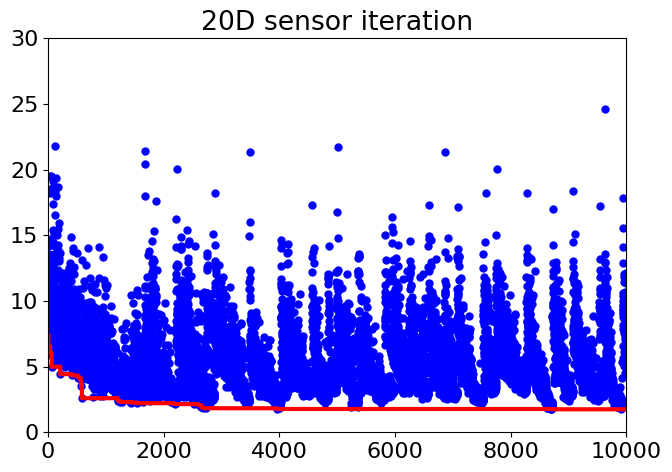

Array saved to ./1000_iter_normal_03252024.txt
Array saved to ./1000_values_03252024.txt


In [29]:
fig = plt.figure(figsize=(7, 5))
matplotlib.rcParams.update({'font.size': 16})
plt.plot(fX, 'b.', ms=10)  # Plot all evaluated points as blue dots
plt.plot(np.minimum.accumulate(fX), 'r', lw=3)  # Plot cumulative minimum as a red line
plt.xlim([0, len(fX)])
plt.ylim([0, 30])
plt.title("%dD sensor iteration" %(int(len(x_best))))

plt.tight_layout()
plt.show()
base_filename = '1000_iter_normal_03252024'
save_array_numpy(np.concatenate((fX, np.minimum.accumulate(fX)), axis=-1), base_filename, folder_path='.')
base_filename2 = '1000_values_03252024'
save_array_numpy(X, base_filename2, folder_path='.')

In [30]:
final_sensor_positions = x_best

# Print or use the final sensor positions
print("Final Sensor Positions:")
print(final_sensor_positions)

Final Sensor Positions:
[31.49191176 11.94716053 47.4024575  10.24149027 25.30450364 14.81949917
 19.97105664  1.81336741 41.98124424 16.89335784 41.26390968  6.98413684
 46.96124783  4.7709943  27.36858491 20.58585638 22.67589839  8.51132274
 48.32623684 15.74297626]


#Sensor verify

In [34]:
sensor_coordinates = np.array(x_best).reshape(-1,2)
D_Train_E = D_Train.reshape(-1,4455,3)
D_Valid_E = D_Valid.reshape(-1,4455,3)

D_Train_w,_ = extract_sensor_data(grid, D_Train_E, len(sensor_coordinates), final_sensor_positions.reshape(-1,2))
D_Valid_w,_ = extract_sensor_data(grid, D_Valid_E, len(sensor_coordinates), final_sensor_positions.reshape(-1,2))

D_Train2 = np.concatenate((D_Train_w, D_Train_L), axis=-1)
D_Valid2 = np.concatenate((D_Valid_w, D_Valid_L), axis=-1)
# Convert to PyTorch tensors and DataLoader
train_loader, valid_loader = prepare_data_loaders(D_Train2, D_Valid2, batch_size=64)

# Define and train the neural network
model = GasLeakDetectorNN(num_sensors = len(sensor_coordinates))
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lrl)


In [35]:
train_losses = []
valid_losses = []
num_epochs = 400
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    train_loss = train_loss/len(train_loader.dataset)

    model.eval()
    valid_loss = 0.0
    original_scale_mse = 0.0
    with torch.no_grad():
        for data, target in valid_loader:
            output = model(data)
            # Inverse transform the output and target to their original scale
            output_np = output.numpy()  # Convert to numpy array if not already
            target_np = target.numpy()
            
            # Inverse transform x coordinates
            output_x_inv = sc_x.inverse_transform(output_np[:, 0].reshape(-1, 1))
            target_x_inv = sc_x.inverse_transform(target_np[:, 0].reshape(-1, 1))
            
            # Inverse transform y coordinates
            output_y_inv = sc_y.inverse_transform(output_np[:, 1].reshape(-1, 1))
            target_y_inv = sc_y.inverse_transform(target_np[:, 1].reshape(-1, 1))
            
            #output_t_inv = sc_t.inverse_transform(output_np[:, 2].reshape(-1, 1))
            #target_t_inv = sc_t.inverse_transform(target_np[:, 2].reshape(-1, 1))
            
            # Concatenate the inversely transformed x and y coordinates
            output_inv = np.concatenate((output_x_inv, output_y_inv), axis=1)
            target_inv = np.concatenate((target_x_inv, target_y_inv), axis=1)
            
            # Calculate MSE on the original scale
            mse_original_scale = mean_squared_error(target_inv, output_inv)
            original_scale_mse += mse_original_scale * data.size(0)
            
            loss = criterion(output, target)
            valid_loss += loss.item()*data.size(0)
            
    valid_loss = valid_loss/len(valid_loader.dataset)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    original_scale_mse = original_scale_mse / len(valid_loader.dataset)
    
    print(f'Validation MSE on Original Scale: {original_scale_mse:.4f}')

Validation MSE on Original Scale: 83.3329
Validation MSE on Original Scale: 63.9134
Validation MSE on Original Scale: 54.7861
Validation MSE on Original Scale: 42.4235
Validation MSE on Original Scale: 30.2830
Validation MSE on Original Scale: 23.5468
Validation MSE on Original Scale: 20.9728
Validation MSE on Original Scale: 19.5945
Validation MSE on Original Scale: 17.9635
Validation MSE on Original Scale: 16.5066
Validation MSE on Original Scale: 15.2363
Validation MSE on Original Scale: 14.2028
Validation MSE on Original Scale: 13.4882
Validation MSE on Original Scale: 12.9967
Validation MSE on Original Scale: 12.6515
Validation MSE on Original Scale: 12.3765
Validation MSE on Original Scale: 12.0798
Validation MSE on Original Scale: 11.8226
Validation MSE on Original Scale: 11.5815
Validation MSE on Original Scale: 11.3753
Validation MSE on Original Scale: 11.1810
Validation MSE on Original Scale: 11.0124
Validation MSE on Original Scale: 10.8115
Validation MSE on Original Scale: 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


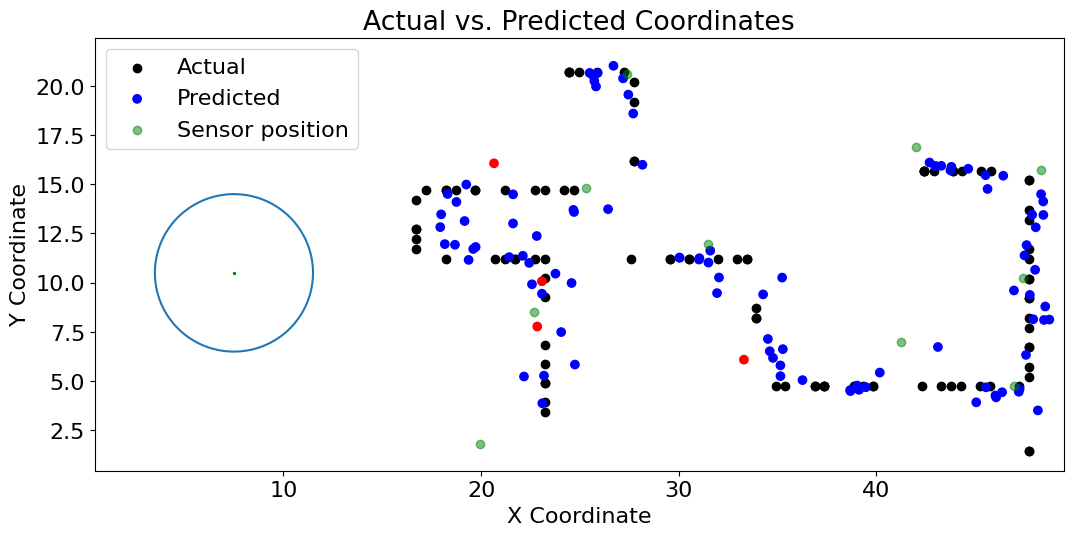

0.961352657004831


In [40]:
model.eval()
predicted_coords = []
actual_coords = []
sensor_np = np.array(final_sensor_positions.reshape(-1,2))

with torch.no_grad():
    for data, target in DataLoader(TensorDataset(torch.tensor(D_Valid2[:, :-2], dtype=torch.float32), torch.tensor(D_Valid2[:, -2:], dtype=torch.float32)), batch_size=64):
        output = model(data)
        predicted_coords.extend(output.numpy())
        actual_coords.extend(target.numpy())

# Inverse Transform Predicted and Actual Coordinates
predicted_coords = np.array(predicted_coords)
actual_coords = np.array(actual_coords)

predicted_x_inv = sc_x.inverse_transform(predicted_coords[:, 0].reshape(-1, 1))
predicted_y_inv = sc_y.inverse_transform(predicted_coords[:, 1].reshape(-1, 1))

actual_x_inv = sc_x.inverse_transform(actual_coords[:, 0].reshape(-1, 1))
actual_y_inv = sc_y.inverse_transform(actual_coords[:, 1].reshape(-1, 1))

x_center = 7.5
y_center = 10.5
radius = 4
decision = np.array([])
distances = np.array([])
for i in range(len(predicted_coords)):
    decision = np.append(decision, 0 if distance((predicted_x_inv[i],predicted_y_inv[i]), (actual_x_inv[i],actual_y_inv[i])) < radius else 1)
    distances = np.append(distances, distance((predicted_x_inv[i],predicted_y_inv[i]), (actual_x_inv[i],actual_y_inv[i])))
print(decision)

theta = np.linspace(0, 2 * np.pi, 100)
x = x_center + radius * np.cos(theta)
y = y_center + radius * np.sin(theta)

#actual_sensor_x = sc_x.inverse_transform(sensor_np[:, 0].reshape(-1, 1))
#actual_sensor_y = sc_y.inverse_transform(sensor_np[:, 1].reshape(-1, 1))
actual_sensor_x = sensor_np[:, 0].reshape(-1, 1)
actual_sensor_y = sensor_np[:, 1].reshape(-1, 1)
n = 100
# Plot Predictions vs. Actual Coordinates
plt.figure(figsize=(12.5, 5.625))
plt.axis([0.4675112982323418, 49.46751129823234, 0.44997892328107925, 22.44997892328108])
plt.scatter(actual_x_inv[:n], actual_y_inv[:n], c='black', label='Actual', alpha=1)
plt.scatter(predicted_x_inv[:n], predicted_y_inv[:n], c=decision[:n], cmap='bwr', label='Predicted', alpha=1)
plt.scatter(actual_sensor_x,actual_sensor_y, c='green', label='Sensor position', alpha = 0.5)

plt.plot(x, y)
plt.scatter(x_center, y_center, color='green', s=2) # Mark the center
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Actual vs. Predicted Coordinates')
plt.legend()
plt.show()
print(1-decision.sum()/len(decision))

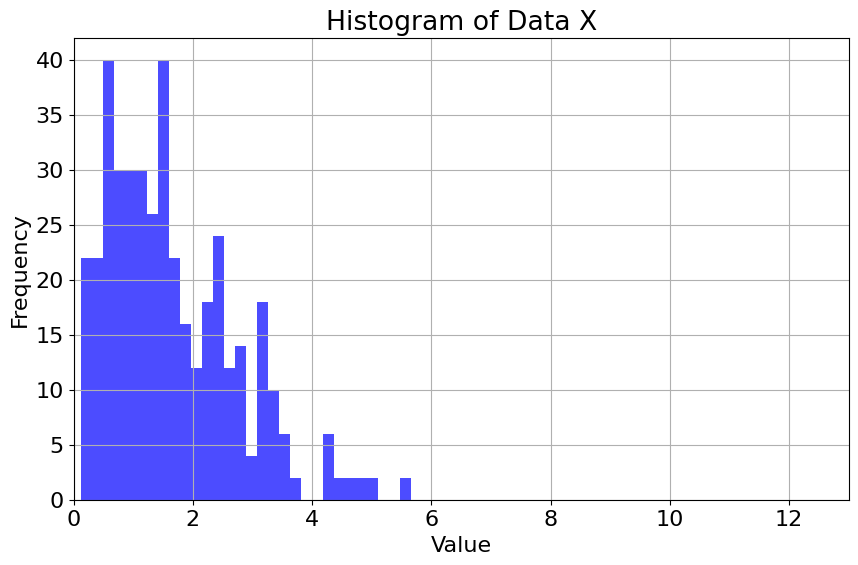

In [43]:
for i in range(len(predicted_coords)):
    decision = np.append(decision, 0 if distance((predicted_x_inv[i],predicted_y_inv[i]), (actual_x_inv[i],actual_y_inv[i])) < radius else 1)
    distances = np.append(distances, distance((predicted_x_inv[i],predicted_y_inv[i]), (actual_x_inv[i],actual_y_inv[i])))
plt.figure(figsize=(10, 6))
plt.hist(distances, bins=30, alpha=0.7, color='blue')
plt.title('Histogram of Data X')
plt.xlim(0, 13)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()